<a href="https://colab.research.google.com/github/jmmiddour/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

## Assignment:

In [33]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
import numpy as np
np.seterr(all='ignore')

# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')


In [34]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [35]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [36]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [37]:
# Look at the first 10 rows of the DataFrame:
df.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019
5,1,UPPER EAST SIDE (79-96),07 RENTALS - WALKUP APARTMENTS,2B,1551,131,NaN,C4,354 EAST 89TH STREET,NaN,10128.0,10.0,0.0,10.0,"2,013",6570.0,1920.0,2,C4,0,01/01/2019
6,1,OTHER,07 RENTALS - WALKUP APARTMENTS,2B,1891,159,NaN,C4,304 WEST 106 STREET,NaN,10025.0,10.0,0.0,10.0,"1,716",5810.0,1900.0,2,C4,0,01/01/2019
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019
8,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,18,NaN,A5,1215 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
9,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,20,NaN,A5,1211 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019


In [38]:
# Look at all the feature names of the DataFrame:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

### Use a subset of the data... 
where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.

In [39]:
# Look at the value counts of BUILDING_CLASS_CATEGORY:
print (df['BUILDING_CLASS_CATEGORY'].value_counts(), '\n')

# Look at the value counts of SALE_PRICE:
print (df['SALE_PRICE'].value_counts())

01 ONE FAMILY DWELLINGS                       5061
02 TWO FAMILY DWELLINGS                       4567
10 COOPS - ELEVATOR APARTMENTS                3471
13 CONDOS - ELEVATOR APARTMENTS               3339
03 THREE FAMILY DWELLINGS                     1438
07 RENTALS - WALKUP APARTMENTS                 807
09 COOPS - WALKUP APARTMENTS                   672
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
04 TAX CLASS 1 CONDOS                          418
44 CONDO PARKING                               366
17 CONDO COOPS                                 300
22 STORE BUILDINGS                             288
05 TAX CLASS 1 VACANT LAND                     288
12 CONDOS - WALKUP APARTMENTS                  256
14 RENTALS - 4-10 UNIT                         200
29 COMMERCIAL GARAGES                          147
08 RENTALS - ELEVATOR APARTMENTS               120
30 WAREHOUSES                                  105
21 OFFICE BUILDINGS                             96
43 CONDO OFFICE BUILDINGS      

In [40]:
# Avoid getting SettingWithCopyWarning by making a copy of DataFrame:
df = df.copy()

# Subset the data as above:
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
         (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]

# Look at the first 10 rows of subset DataFrame:
df.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019
120,3,OTHER,01 ONE FAMILY DWELLINGS,1,6806,72,NaN,A1,1747 EAST 23RD STREET,NaN,11229.0,1.0,0.0,1.0,"4,000",1932.0,1930.0,1,A1,1150000,01/02/2019
121,3,OTHER,01 ONE FAMILY DWELLINGS,1,6761,42,NaN,A1,1582 EAST 15TH STREET,NaN,11230.0,1.0,0.0,1.0,"2,000",1722.0,1920.0,1,A1,836500,01/02/2019
132,4,OTHER,01 ONE FAMILY DWELLINGS,1,7378,4,NaN,A1,201-08 50TH AVENUE,NaN,11364.0,1.0,0.0,1.0,"3,000",1396.0,1930.0,1,A1,955000,01/02/2019
137,4,OTHER,01 ONE FAMILY DWELLINGS,1,2882,16,NaN,A5,85-11 57 ROAD,NaN,11373.0,1.0,0.0,1.0,"1,800",1260.0,1935.0,1,A5,820000,01/02/2019
141,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,7407,50,NaN,A0,53-19 198TH STREET,NaN,11365.0,1.0,0.0,1.0,"4,000",1440.0,1945.0,1,A0,980000,01/02/2019


In [41]:
# Check my work by looking at the shape and value counts of columns I subsetted on:
print (df.shape)
print (df['BUILDING_CLASS_CATEGORY'].value_counts(), '\n')
print (df['SALE_PRICE'].value_counts())

(3151, 21)
01 ONE FAMILY DWELLINGS    3151
Name: BUILDING_CLASS_CATEGORY, dtype: int64 

500000    48
550000    43
450000    40
525000    40
650000    36
          ..
413000     1
672045     1
457000     1
608550     1
727000     1
Name: SALE_PRICE, Length: 1000, dtype: int64


### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [42]:
# Look at the type of data in the SALE_DATE column:
df['SALE_DATE'].dtypes

dtype('O')

In [43]:
# Turn SALE_DATE into datetime type:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

# Check my work:
df['SALE_DATE'].dtypes

dtype('<M8[ns]')

In [44]:
# Look at the first 5 rows to see how the values are formatted now:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [45]:
# Split the dataframe into train and test:
train = df[df['SALE_DATE'] < '2019-04-01']
test = df[df['SALE_DATE'] >= '2019-04-01']

# Check my work:
train.shape, test.shape

((2507, 21), (644, 21))

### Do one-hot encoding of categorical features.

In [46]:
# Look at the numerical columns:
df.describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3151.000000,3151.000000,0.0,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.0,3.151000e+03
mean,6917.976515,75.981593,NaN,11027.219613,0.987623,0.015868,1.003491,1470.306887,1943.694700,1.0,6.285601e+05
std,3963.326705,161.089514,NaN,482.875284,0.113414,0.127499,0.171789,586.339200,26.676786,0.0,2.929904e+05
min,21.000000,1.000000,NaN,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,4016.000000,21.000000,NaN,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.475000e+05
50%,6301.000000,42.000000,NaN,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.680000e+05
75%,10208.500000,69.000000,NaN,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,NaN,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [47]:
# Look at non-numeric columns first:
df.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,3151,3151,3151,3151,3151,3151,1,3151,3151,3151
unique,5,7,1,2,13,3135,1,1035,11,91
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,94 CELESTE COURT,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1580,2959,3151,3111,1185,2,1,289,1186,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-30 00:00:00


In [48]:
# Look at the value counts of EASE-MENT because it looks like it is an empty column:
print (train['EASE-MENT'].value_counts())
print (test['EASE-MENT'].value_counts())

# It is an empty column, so going to drop it:
train = train.drop(columns=['EASE-MENT'])
test = test.drop(columns=['EASE-MENT'])

# Check my work:
train.columns, test.columns

Series([], Name: EASE-MENT, dtype: int64)
Series([], Name: EASE-MENT, dtype: int64)


(Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
        'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
        'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
        'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
        'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
        'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE'],
       dtype='object'),
 Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
        'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
        'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
        'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
        'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
        'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE'],
       dtype='object'))

In [49]:
# Look at value counts for APARTMENT_NUMBER because there are a lot of NaN showing:
train['APARTMENT_NUMBER'].value_counts()

RP.    1
Name: APARTMENT_NUMBER, dtype: int64

In [50]:
# Look at value counts for APARTMENT_NUMBER for test set too:
test['APARTMENT_NUMBER'].value_counts()

Series([], Name: APARTMENT_NUMBER, dtype: int64)

In [51]:
# Drop APARTMENT_NUMBER column in both train and test because there is only 
  # 1 value in the whole column in train and none in test:
train = train.drop(columns='APARTMENT_NUMBER')
test = test.drop(columns='APARTMENT_NUMBER')

# Check my work:
train.columns, test.columns

(Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
        'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
        'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
        'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
        'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
        'SALE_PRICE', 'SALE_DATE'],
       dtype='object'),
 Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
        'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
        'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
        'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
        'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
        'SALE_PRICE', 'SALE_DATE'],
       dtype='object'))

In [52]:
# Create a variable for my target values:
target = 'SALE_PRICE'

# Eliminate categorical values that are High Cardinality:
high_card = ['BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'LAND_SQUARE_FEET', 
             'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']

# Create my features:
features = train.columns.drop([target] + high_card)

# Check my work:
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [53]:
# Arrange features (X):
X_train = train[features]
X_test = test[features]

# Arrange targets (y):
y_train = train[target]
y_test = test[target]

In [54]:
# Look at X_train before encoding:
X_train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,5,OTHER,01 ONE FAMILY DWELLINGS,1,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,5,OTHER,01 ONE FAMILY DWELLINGS,1,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,5,OTHER,01 ONE FAMILY DWELLINGS,1,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,5,OTHER,01 ONE FAMILY DWELLINGS,1,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1


In [55]:
# Import new library:
import category_encoders as ce
import pandas.util.testing as tm

# Create a variable for new encoder object:
encoder = ce.OneHotEncoder(use_cat_names=True)

# Use the fit_transform method on the train set:
X_train = encoder.fit_transform(X_train)

# Use the transform method on the test set:
X_test = encoder.transform(X_test)

In [56]:
# Look at X_train now:
X_train

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1


### Do feature selection with `SelectKBest`.

In [57]:
# Import more libraries:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

# Find out how many features I should be selecting:
for k in range(1, len(X_train.columns) + 1):
  print (f'{k} feature(s)')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_sel = selector.fit_transform(X_train, y_train)
  X_test_sel = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_sel, y_train)
  y_pred = model.predict(X_test_sel)
  mae = mean_absolute_error(y_test, y_pred)

  print (f'Test Mean Absolute Error (MAE): ${mae:,.2f}\n')

1 feature(s)
Test Mean Absolute Error (MAE): $183,640.59

2 feature(s)
Test Mean Absolute Error (MAE): $184,336.67

3 feature(s)
Test Mean Absolute Error (MAE): $183,041.39

4 feature(s)
Test Mean Absolute Error (MAE): $177,282.06

5 feature(s)
Test Mean Absolute Error (MAE): $177,883.72

6 feature(s)
Test Mean Absolute Error (MAE): $177,481.60

7 feature(s)
Test Mean Absolute Error (MAE): $172,592.55

8 feature(s)
Test Mean Absolute Error (MAE): $171,870.28

9 feature(s)
Test Mean Absolute Error (MAE): $171,227.50

10 feature(s)
Test Mean Absolute Error (MAE): $163,252.18

11 feature(s)
Test Mean Absolute Error (MAE): $164,473.50

12 feature(s)
Test Mean Absolute Error (MAE): $160,247.33

13 feature(s)
Test Mean Absolute Error (MAE): $160,334.46

14 feature(s)
Test Mean Absolute Error (MAE): $160,334.46

15 feature(s)
Test Mean Absolute Error (MAE): $160,122.58

16 feature(s)
Test Mean Absolute Error (MAE): $160,031.78

17 feature(s)
Test Mean Absolute Error (MAE): $160,552.26

18 fea

- Since it is showing 12 features being the best MAE without a lot of noise that is what I will use.

In [58]:
# Import new libraries:
from math import factorial
from sklearn.feature_selection import SelectKBest, f_regression

# Create a selector object:
selector = SelectKBest(k=12)

# Create new variables to fit the selector to:
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Look at the shape before selector is fit:
print ('X Train & Test shape before selector:', X_train.shape, X_test.shape)

# Look at shape after selector is fit:
print ('X Train & Test shape after selector:', X_train_sel.shape, X_test_sel.shape)

X Train & Test shape before selector: (2507, 24) (644, 24)
X Train & Test shape after selector: (2507, 12) (644, 12)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 23] are constant.
  UserWarning)


In [59]:
# Which features were selected:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

# Look at the feature names that were selected and those that were not:
print ('Features Selected:')
for name in selected_names:
  print (name)
print ('\n')
print ('Features not Selected:')
for name in unselected_names:
  print (name)

Features Selected:
BOROUGH_1
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT


Features not Selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
BLOCK
ZIP_CODE
TAX_CLASS_AT_TIME_OF_SALE


### Fit a ridge regression model with multiple features. 
Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)

In [60]:
# Import more libraries:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
%matplotlib inline


Ridge Regression, with alpha=0.01
Test Mean Absolute Error (MAE): $160,544.58



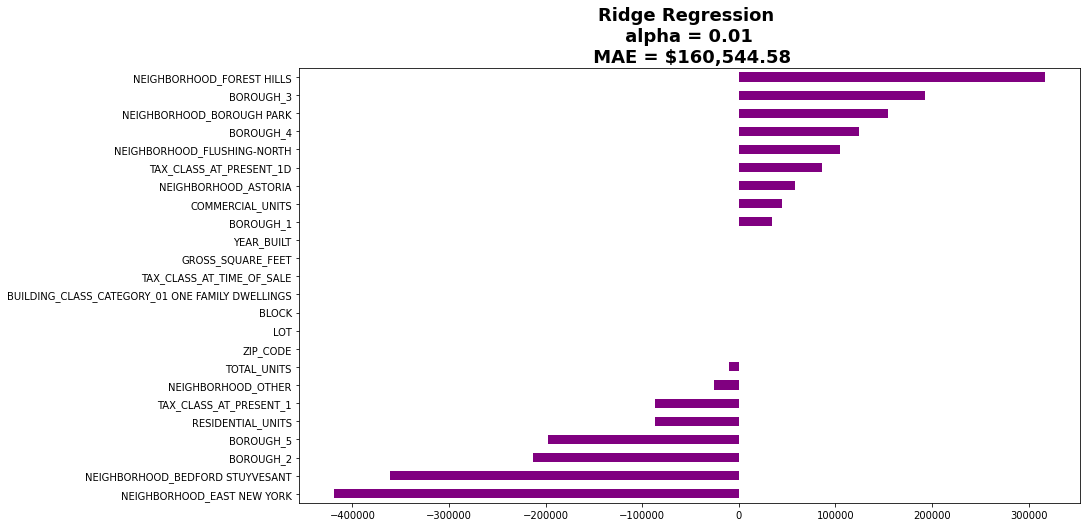


Ridge Regression, with alpha=0.1
Test Mean Absolute Error (MAE): $161,034.17



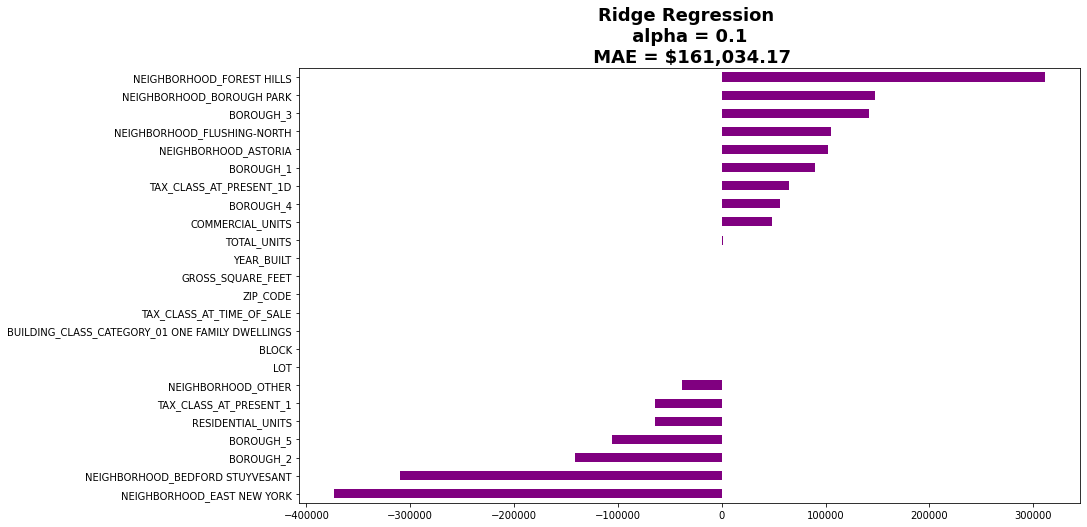


Ridge Regression, with alpha=0.5
Test Mean Absolute Error (MAE): $166,991.66



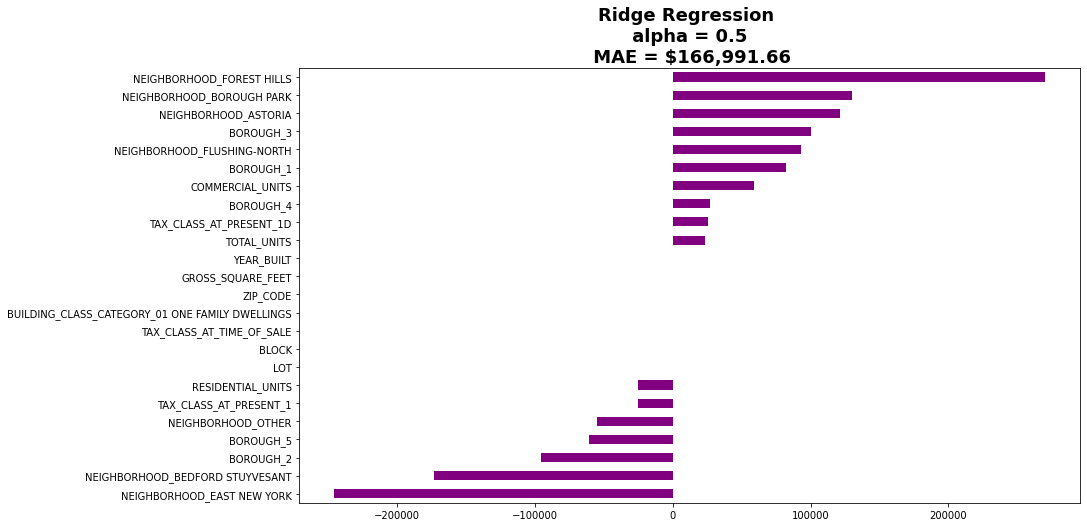


Ridge Regression, with alpha=1.0
Test Mean Absolute Error (MAE): $174,137.91



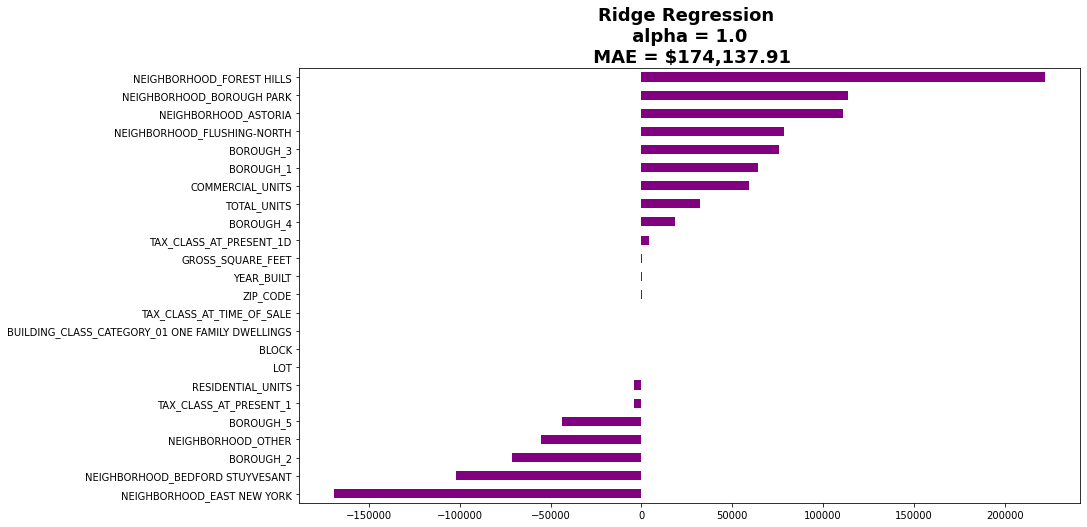


Ridge Regression, with alpha=10.0
Test Mean Absolute Error (MAE): $202,235.71



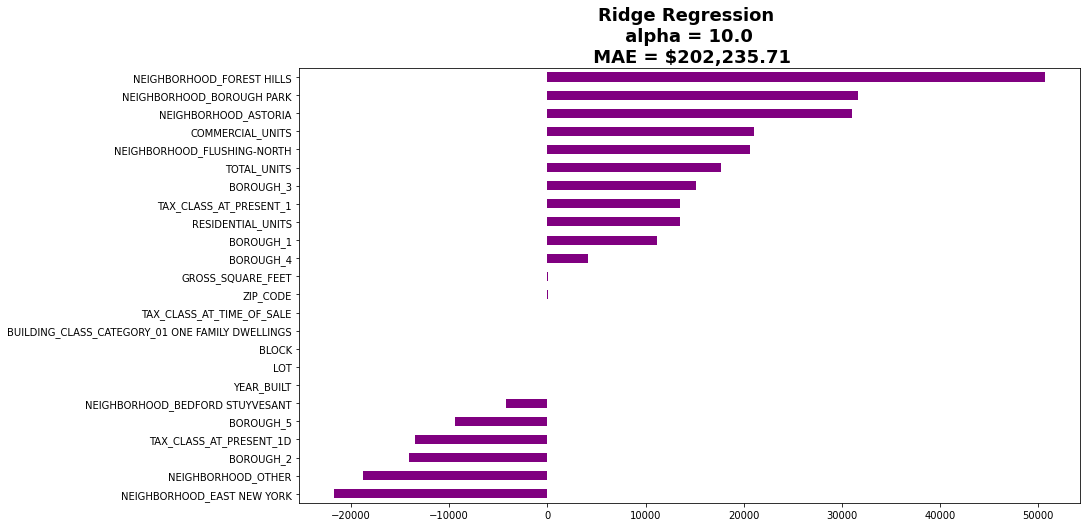


Ridge Regression, with alpha=50.0
Test Mean Absolute Error (MAE): $209,362.40



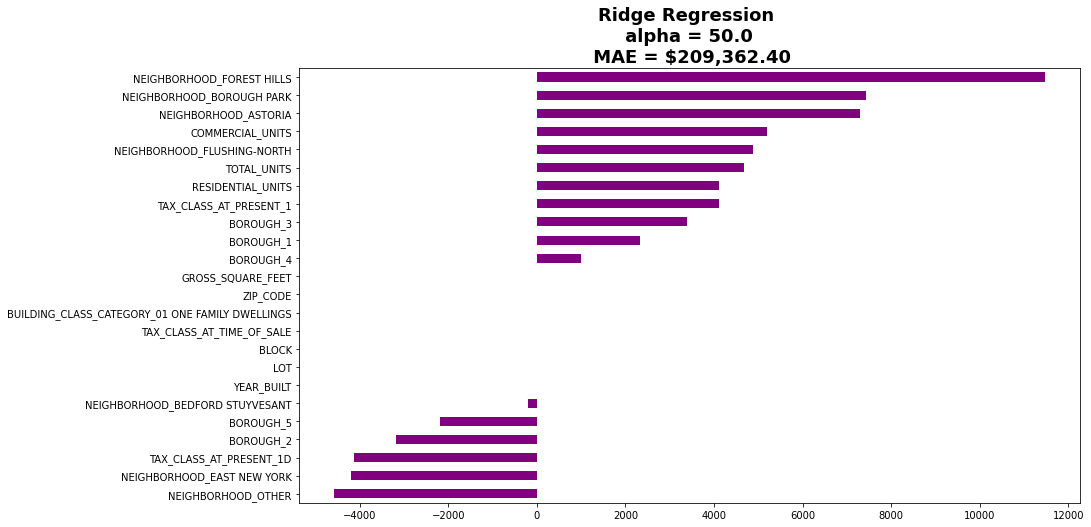

In [67]:
# Run a for loop to iterate through different alpha values:
for alpha in [0.01, 0.1, 0.5, 1.0, 10.0, 50.0]:
  
  # Fit a Ridge regression:
  print (f'\nRidge Regression, with alpha={alpha}')
  model = Ridge(alpha=alpha, normalize=True)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # Get the test MAE:
  mae = mean_absolute_error(y_test, y_pred)
  print (f'Test Mean Absolute Error (MAE): ${mae:,.2f}\n')

  # Plot the coefficents:
  coefficients = pd.Series(model.coef_, X_train.columns)
  plt.figure(figsize=(14, 8), facecolor='white')
  coefficients.sort_values().plot.barh(color='purple')
  plt.title(f'Ridge Regression \n alpha = {alpha} \n MAE = ${mae:,.2f}', 
            size=18, weight='bold')
  plt.show()

### Get mean absolute error for the test set.

In [68]:
# MAE for the test set:
print (f'Mean Absolute Error (MEA) for Test set: ${mean_absolute_error(y_test, y_pred):,.2f}')

Mean Absolute Error (MEA) for Test set: $209,362.40


### As always, commit your notebook to your fork of the GitHub repo.

In [69]:
# Done!

## Stretch Goals:

### Add your own stretch goal(s) !

### Instead of `Ridge`, try `LinearRegression`. 
Depending on how many features you select, your errors will probably blow up! 💥

### Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

### Learn more about feature selection:
  - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
  - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
  - [mlxtend](http://rasbt.github.io/mlxtend/) library
  - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
  - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.

### Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in...
 more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.

### Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), 
Chapters 1-3, for more math & theory, but in an accessible, readable way.

In [32]:
# Done!

### Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class GaussianFeatures(BaseEstimator, TransformerMixin):
#   '''
#   Uniformly spaced Gaussian Features for one-dimensional imput.
#   '''
#   def __init__(self, N, width_factor=2.0):
#     self.N = N
#     self.width_factor = width_factor

#   @staticmethod
#   def _gauss_basis(X_train, y_train, width, axis=None):
#     arg = (X_train - y_train) / width
#     return np.exp(-0.5 * np.sum(arg ** 2, axis))

#   def fit(self, )

In [ ]:
# coeff = pd.Series(model.coef_, X_train.columns)

# def basis_plot (model, title=None):
#   fig, ax = plt.subplots(2, sharex=True)
#   model.fit(X_train, y_train)
#   ax[0].barh(X_train, y_train)
#   ax[0].plot(coeff, y_pred)
#   ax[0].set()

In [ ]:
# from  sklearn.pipeline import make_pipeline

# model = make_pipeline(GaussianFeatures(24), Ridge(alpha=0.01))
# basis_plot(model, title='Ridge Regression using Pipeline')